In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. Importando bibliotecas utilizadas

In [6]:
!pip install imgaug

In [8]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from skimage.color import rgb2hsv
from tqdm import tqdm
from imgaug import augmenters as iaa
from imgaug import Keypoint, KeypointsOnImage
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## 1. Carregando os dados do dataset ANIMAL-POSE

In [ ]:
path_to_json = '/content/drive/MyDrive/Colab Notebooks/m10/sem8/hayashi-ponderada/keypoints.json'
with open(path_to_json, 'r') as file:
    keypoints_data = json.load(file)

In [ ]:
path_to_images = '/content/drive/MyDrive/Colab Notebooks/m10/sem8/hayashi-ponderada/images'

image_data = []
keypoints_dict = {ann['image_id']: ann for ann in keypoints_data['annotations']}
categories = {cat['id']: cat for cat in keypoints_data['categories']}

for image_id, image_name in tqdm(list(keypoints_data['images'].items())):
    if int(image_id) in keypoints_dict:
        data = keypoints_dict[int(image_id)]
        image_path = f'{path_to_images}/{image_name}'
        image = Image.open(image_path)
        np_image = np.array(image)

        category_details = categories[data['category_id']]

        image_info = {
            'image_path': image_path,
            'np_image': np_image,
            'keypoints': data['keypoints'],
            'bbox': data['bbox'],
            'category_id': data['category_id'],
            'category_name': category_details['name'],
            'keypoint_names': category_details['keypoints'],
            'skeleton': category_details['skeleton']
        }
        image_data.append(image_info)

100%|██████████| 4608/4608 [16:18<00:00,  4.71it/s]


## 2. Visualizando algumas imagens

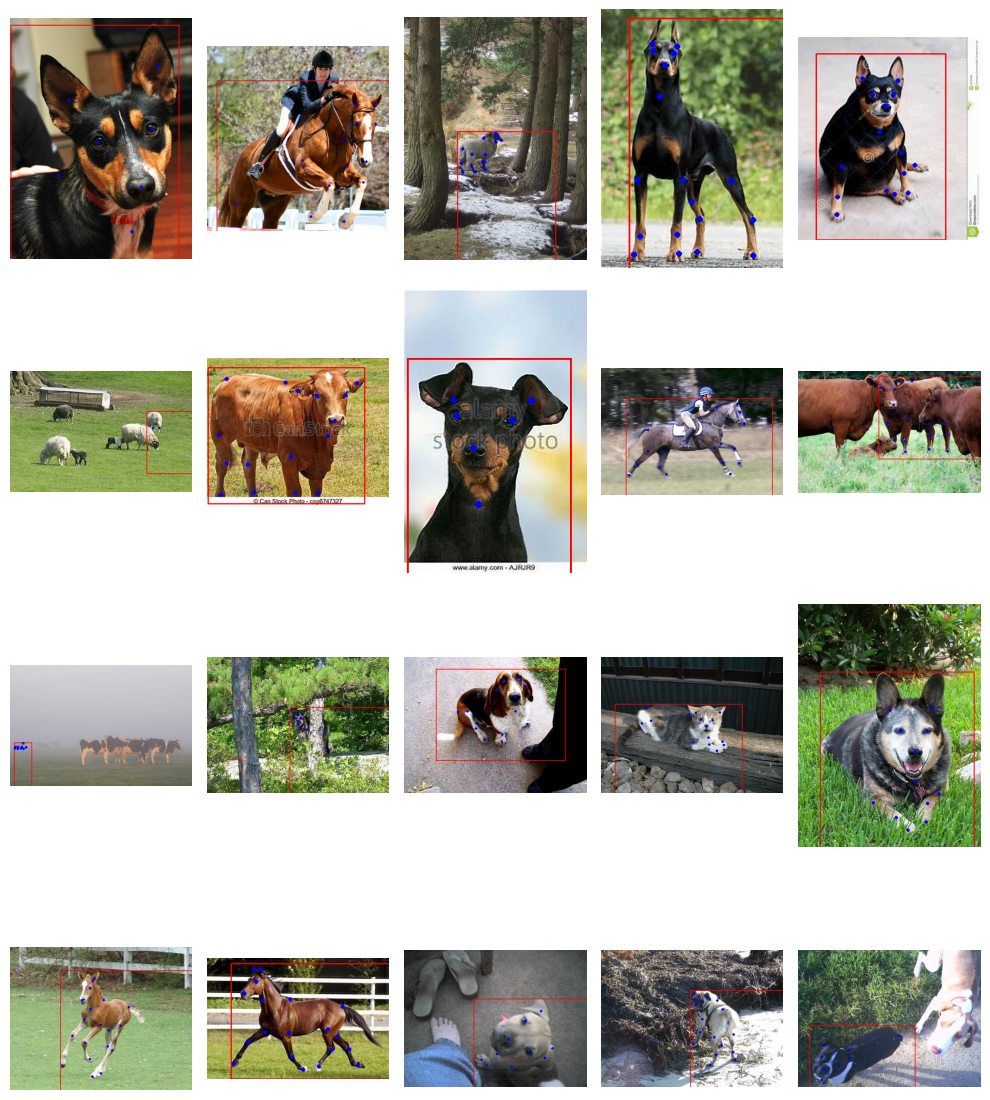

In [ ]:
images_per_row = 5
N = 20

sampled_images = random.sample(image_data, N)
num_rows = N // images_per_row + (N % images_per_row > 0)

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(2 * images_per_row, 3 * num_rows))

axes = axes.flatten() if num_rows > 1 else [axes]

def draw_keypoints_and_bbox(draw, keypoints, bbox):
    bbox_rect = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
    draw.rectangle(bbox_rect, outline="red", width=2)

    for x, y, v in keypoints:
        if v == 1:
            draw.ellipse((x - 3, y - 3, x + 3, y + 3), fill='blue')

for idx, (data, ax) in enumerate(zip(sampled_images, axes)):
    image_array = data['np_image']
    image = Image.fromarray(image_array)
    draw = ImageDraw.Draw(image)

    draw_keypoints_and_bbox(draw, data['keypoints'], data['bbox'])

    ax.imshow(image)
    ax.axis('off')

if N < num_rows * images_per_row:
    for ax in axes[N:]:
        ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Análise Exploratória

### 3.1 Distribuição do tamanho das imagens

A distribuição do tamanho das imagens é importante pois pode influenciar significamente em como o pré-processamento das imagens deve ser feito. Saber se todas as imagens têm dimensões uniformes ou variadas ajuda no pré-processamento, indicando possível necessidade de redimensionamento e normalização. Esta análise mostra um histograma das larguras e alturas das imagens, fornecendo uma visão da variedade de dimensões presentes.

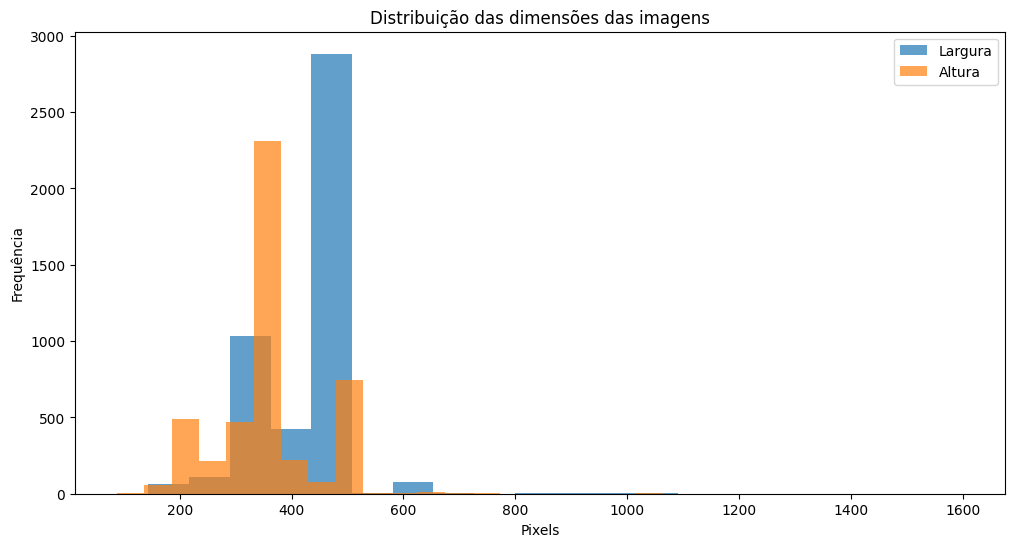

In [ ]:
widths = [img['np_image'].shape[1] for img in image_data]
heights = [img['np_image'].shape[0] for img in image_data]

plt.figure(figsize=(12, 6))
plt.hist(widths, bins=20, alpha=0.7, label='Largura')
plt.hist(heights, bins=20, alpha=0.7, label='Altura')
plt.title('Distribuição das dimensões das imagens')
plt.xlabel('Pixels')
plt.ylabel('Frequência')
plt.legend()
plt.show()


### 3.2 Histograma de intensidades de cores

O histograma agregado de cores para um conjunto de imagens mostre uma visão sobre a distribuição geral de cores nas imagens do dataset. Isso pode ser útil para indicar alguns pré-processamentos que devem ser feitos nas imagens, como correção e equalização de cores. Fazendo essa análise também dá para identificar outliers e possíveis viéses nos dados.

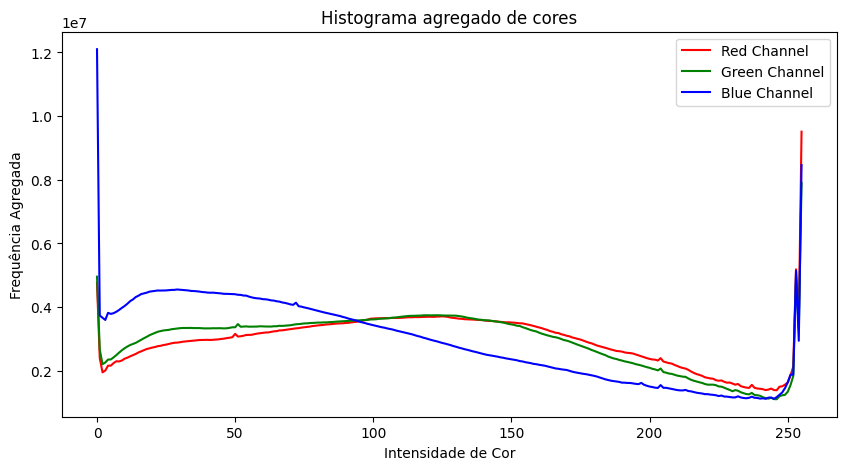

In [ ]:
def compute_histogram(np_image):
    red_hist = np.histogram(np_image[:,:,0], bins=256, range=(0,256))[0]
    green_hist = np.histogram(np_image[:,:,1], bins=256, range=(0,256))[0]
    blue_hist = np.histogram(np_image[:,:,2], bins=256, range=(0,256))[0]
    return red_hist, green_hist, blue_hist

aggregate_red_hist = np.zeros(256)
aggregate_green_hist = np.zeros(256)
aggregate_blue_hist = np.zeros(256)

for item in image_data:
    red_hist, green_hist, blue_hist = compute_histogram(item['np_image'])
    aggregate_red_hist += red_hist
    aggregate_green_hist += green_hist
    aggregate_blue_hist += blue_hist

plt.figure(figsize=(10, 5))
plt.plot(aggregate_red_hist, color='red', label='Red Channel')
plt.plot(aggregate_green_hist, color='green', label='Green Channel')
plt.plot(aggregate_blue_hist, color='blue', label='Blue Channel')
plt.title('Histograma agregado de cores')
plt.xlabel('Intensidade de Cor')
plt.ylabel('Frequência Agregada')
plt.legend()
plt.show()


### 3.3 Saturação e Birlho Médios

As análises de brilho médio e saturação média ajudam a determinar a necessidade de ajustes de pré-processamento como normalização de iluminação e correção de cor.

O brilho médio revela se as imagens são geralmente claras ou escuras, o que é bem importante saber para ajustar a exposição ou contraste das imagens antes de treinar os modelos. Já a saturação média indica a "vivacidade" das cores, indicando também possíveis ajustes e viéses.

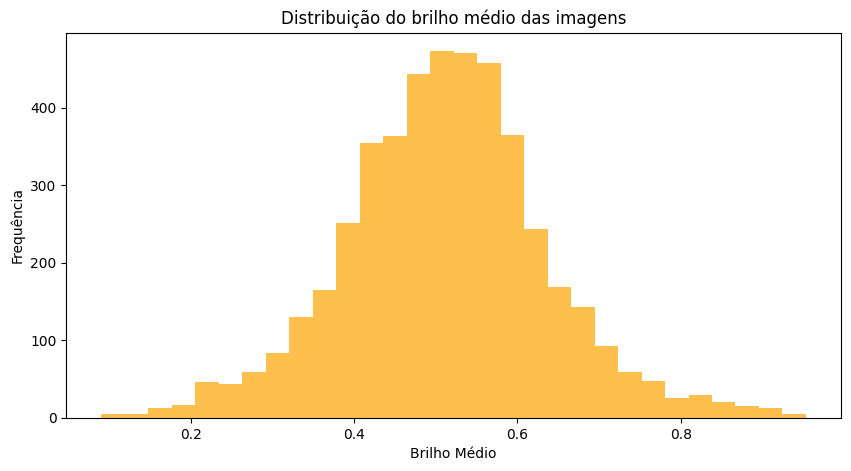

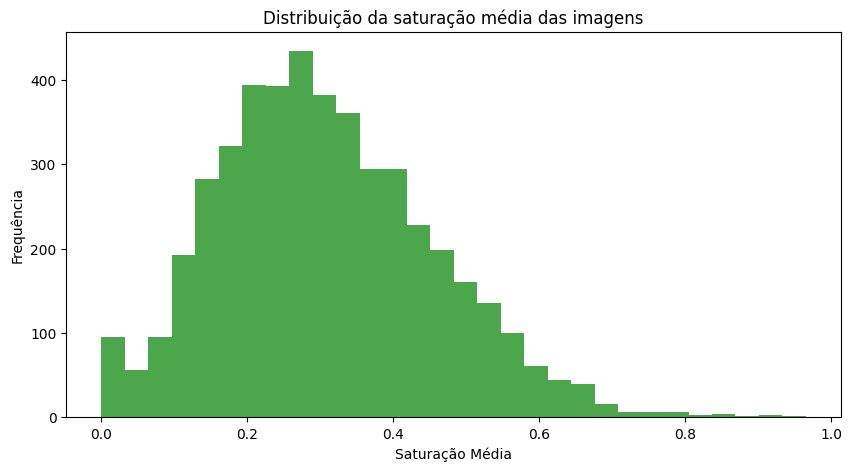

In [ ]:
def calculate_brightness_and_saturation(np_image):
    hsv_image = rgb2hsv(np_image)
    brightness = np.mean(hsv_image[:, :, 2])
    saturation = np.mean(hsv_image[:, :, 1])
    return brightness, saturation

brightness_levels = []
saturations = []
for data in image_data:
    brightness, saturation = calculate_brightness_and_saturation(data['np_image'])
    brightness_levels.append(brightness)
    saturations.append(saturation)

plt.figure(figsize=(10, 5))
plt.hist(brightness_levels, bins=30, color='orange', alpha=0.7)
plt.title('Distribuição do brilho médio das imagens')
plt.xlabel('Brilho Médio')
plt.ylabel('Frequência')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(saturations, bins=30, color='green', alpha=0.7)
plt.title('Distribuição da saturação média das imagens')
plt.xlabel('Saturação Média')
plt.ylabel('Frequência')
plt.show()

### 3.4 Análise de textura usando variância de cor

A análise de textura usando a variância de cor é importante para entender sobre a regularidade ou irregularidade dos padrões de cor. Compreender a variância de cor ajuda nos processos de pré-processamento e melhoria de imagem, garantindo que as características relevantes sejam realçadas ou suavizadas conforme necessário.

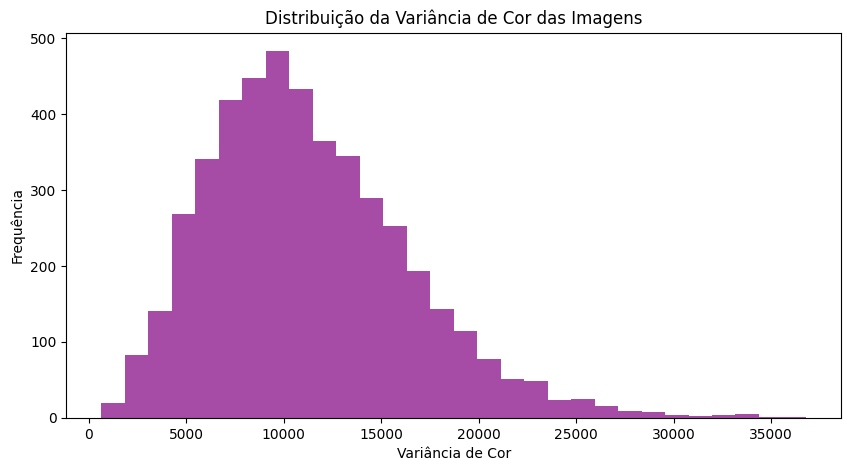

In [ ]:
def color_variance(np_image):
    red_var = np.var(np_image[:, :, 0])
    green_var = np.var(np_image[:, :, 1])
    blue_var = np.var(np_image[:, :, 2])
    return red_var + green_var + blue_var

color_variances = [color_variance(data['np_image']) for data in image_data]

plt.figure(figsize=(10, 5))
plt.hist(color_variances, bins=30, color='purple', alpha=0.7)
plt.title('Distribuição da Variância de Cor das Imagens')
plt.xlabel('Variância de Cor')
plt.ylabel('Frequência')
plt.show()

## 4. Separando apenas bovinos

### 4.1 Listando todas as categorias

In [ ]:
categories = keypoints_data['categories']

for category in categories:
    print(f"ID: {category['id']}, Name: {category['name']}, Supercategory: {category['supercategory']}")

ID: 1, Name: dog, Supercategory: animal
ID: 2, Name: cat, Supercategory: animal
ID: 3, Name: sheep, Supercategory: animal
ID: 4, Name: horse, Supercategory: animal
ID: 5, Name: cow, Supercategory: animal


### 4.2 Filtrando para pegar apenas as imagens referentes a categoria 5 (cow)

In [ ]:
bovine_images = [data for data in image_data if data['category_id'] == 5]
print(f"Total de imagens: {len(image_data)}")
print(f"Total de imagens de bovinos (vacas): {len(bovine_images)}")

Total de imagens: 4608
Total de imagens de bovinos (vacas): 532


In [ ]:
bovine_image_paths = [data['image_path'] for data in bovine_images]
output_json_path = '/content/drive/MyDrive/Colab Notebooks/m10/sem8/hayashi-ponderada/bovine_image_paths.json'
with open(output_json_path, 'w') as json_file:
    json.dump(bovine_image_paths, json_file)
print(f'Saved {len(bovine_image_paths)} bovine image paths to {output_json_path}')

Saved 532 bovine image paths to /content/drive/MyDrive/Colab Notebooks/m10/sem8/hayashi-ponderada/bovine_image_paths.json


### 4.3 Carregando apenas imagens de bovinos

In [9]:
path_to_image_paths_json = '/content/drive/MyDrive/Colab Notebooks/m10/sem8/hayashi-ponderada/bovine_image_paths.json'
path_to_keypoints_json = '/content/drive/MyDrive/Colab Notebooks/m10/sem8/hayashi-ponderada/keypoints.json'
path_to_images = '/content/drive/MyDrive/Colab Notebooks/m10/sem8/hayashi-ponderada/images'

with open(path_to_image_paths_json, 'r') as file:
    bovine_image_paths = json.load(file)

with open(path_to_keypoints_json, 'r') as file:
    keypoints_data = json.load(file)

keypoints_dict = {ann['image_id']: ann for ann in keypoints_data['annotations']}
categories = {cat['id']: cat for cat in keypoints_data['categories']}

bovine_images = []

for image_path in tqdm(bovine_image_paths):
    image_name = image_path.split('/')[-1]
    image_id = next((id for id, name in keypoints_data['images'].items() if name == image_name), None)

    if image_id and int(image_id) in keypoints_dict:
        data = keypoints_dict[int(image_id)]
        image = Image.open(image_path)
        np_image = np.array(image)

        category_details = categories[data['category_id']]

        image_info = {
            'image_path': image_path,
            'np_image': np_image,
            'keypoints': data['keypoints'],
            'bbox': data['bbox'],
            'category_id': data['category_id'],
            'category_name': category_details['name'],
            'keypoint_names': category_details['keypoints'],
            'skeleton': category_details['skeleton']
        }
        bovine_images.append(image_info)

print(f'Loaded {len(bovine_images)} images.')

100%|██████████| 532/532 [00:07<00:00, 68.08it/s] 

Loaded 532 images.


## 5. Pré-processamento dos dados

### 5.1 Aplicando o pré-processamento

In [10]:
def preprocess_and_augment(image_info, output_size=(400, 400), max_keypoints=19):
    image = image_info['np_image']
    keypoints = image_info['keypoints']

    seq = iaa.Sequential([
        iaa.Resize({"height": output_size[1], "width": output_size[0]}),
        iaa.Fliplr(0.5),  # Horizontal flip 50% of the time
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25)
        )
    ], random_order=True)

    keypoints_ia = [Keypoint(x=point[0], y=point[1]) for point in keypoints if point[2] > 0]
    keypoints_on_image = KeypointsOnImage(keypoints_ia, shape=image.shape)

    image_aug, keypoints_aug = seq(image=image, keypoints=keypoints_on_image)
    image_aug = image_aug / 255.0  # Normalize the image to 0-1 range

    keypoints_normalized = [(kp.x / output_size[0], kp.y / output_size[1]) for kp in keypoints_aug.keypoints]
    while len(keypoints_normalized) < max_keypoints:
        keypoints_normalized.append((0, 0))  # Pad with zeros if fewer keypoints detected

    return image_aug, np.array(keypoints_normalized).flatten()

In [11]:
max_keypoints = max(len(item['keypoints']) for item in bovine_images)
x_train = []
y_train = []

for item in tqdm(bovine_images):
    processed_image, processed_keypoints = preprocess_and_augment(item, max_keypoints=max_keypoints)
    x_train.append(processed_image)
    y_train.append(processed_keypoints)

x_train = np.array(x_train)
y_train = np.array(y_train)

100%|██████████| 532/532 [00:05<00:00, 104.70it/s]


### 5.2 Visualizando o pré processamento

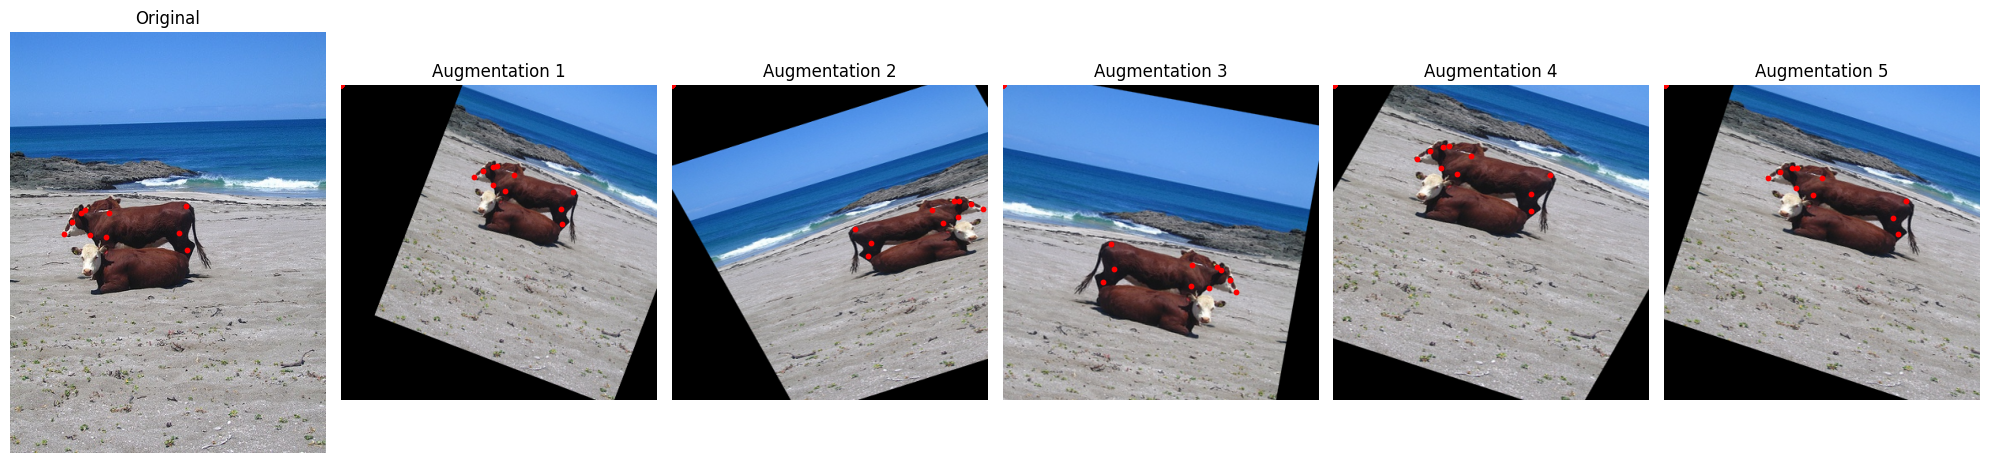

In [12]:
def visualize_processing(image_info, num_augmentations=5):
    plt.figure(figsize=(20, 10))

    plt.subplot(2, num_augmentations + 1, 1)
    plt.imshow(image_info['np_image'])
    plt.title("Original")
    plt.axis('off')

    original_keypoints = np.array([(kp[0], kp[1]) for kp in image_info['keypoints'] if kp[2] > 0])
    plt.scatter(original_keypoints[:, 0], original_keypoints[:, 1], c='r', s=10)

    for i in range(num_augmentations):
        augmented_image, augmented_keypoints = preprocess_and_augment(image_info)
        plt.subplot(2, num_augmentations + 1, i + 2)
        plt.imshow(augmented_image)
        augmented_keypoints = augmented_keypoints.reshape(-1, 2)
        plt.scatter(augmented_keypoints[:, 0] * 400, augmented_keypoints[:, 1] * 400, c='r', s=10)
        plt.title(f"Augmentation {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

sample_item = bovine_images[0]
visualize_processing(sample_item, num_augmentations=5)

## 6. Treinamento do modelo

In [13]:
x_train.shape

(532, 400, 400, 3)

In [14]:
y_train.shape

(532, 40)

In [15]:
max_keypoints

20

In [18]:
def create_pose_estimation_model(input_shape, num_keypoints):
    model = Sequential([
        Conv2D(8, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_keypoints * 2, activation='sigmoid')  # x, y coordinates for each keypoint
    ])
    return model

input_shape = (400, 400, 3)
num_keypoints = 20
model = create_pose_estimation_model(input_shape, num_keypoints)
model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 398, 398, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 199, 199, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 197, 197, 16)      1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 98, 98, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 48, 48, 32)       

In [19]:
# Supondo que x_train e y_train estejam preparados corretamente
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
14/14 [==============================] - 48s 3s/step - loss: 0.1420 - accuracy: 0.0212 - val_loss: 0.1094 - val_accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 44s 3s/step - loss: 0.1202 - accuracy: 0.0424 - val_loss: 0.1007 - val_accuracy: 0.0467
Epoch 3/25
14/14 [==============================] - 61s 4s/step - loss: 0.1119 - accuracy: 0.0329 - val_loss: 0.0960 - val_accuracy: 0.0467
Epoch 4/25
14/14 [==============================] - 47s 3s/step - loss: 0.1055 - accuracy: 0.0282 - val_loss: 0.0916 - val_accuracy: 0.0561
Epoch 5/25
14/14 [==============================] - 45s 3s/step - loss: 0.0979 - accuracy: 0.0306 - val_loss: 0.0898 - val_accuracy: 0.0467
Epoch 6/25
14/14 [==============================] - 47s 3s/step - loss: 0.0919 - accuracy: 0.0541 - val_loss: 0.0896 - val_accuracy: 0.0187
Epoch 7/25
14/14 [==============================] - 44s 3s/step - loss: 0.0868 - accuracy: 0.0612 - val_loss: 0.0922 - val_accuracy: 0.0467
Epoch 8/25
14/14

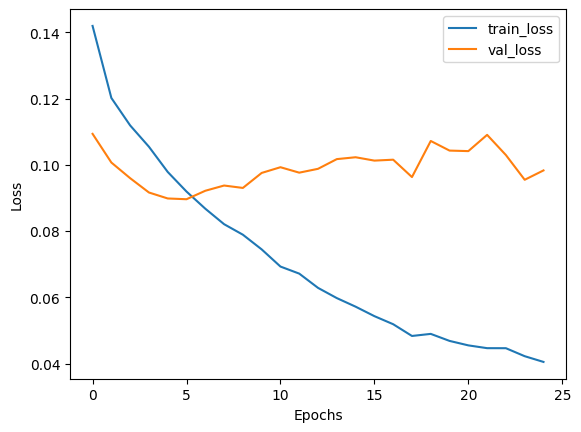

In [20]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
loss = model.evaluate(x_train, y_train)
print(f'Final loss on training set: {loss}')

17/17 [==============================] - 23s 1s/step - loss: 0.0408 - accuracy: 0.1297
Final loss on training set: [0.040845837444067, 0.129699245095253]


1/1 [==============================] - 0s 89ms/step


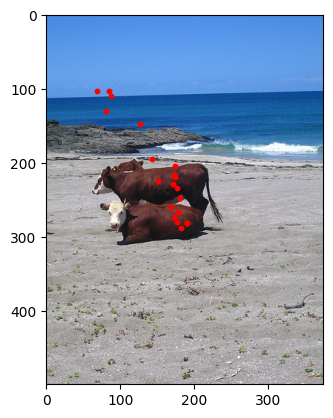

1/1 [==============================] - 0s 113ms/step


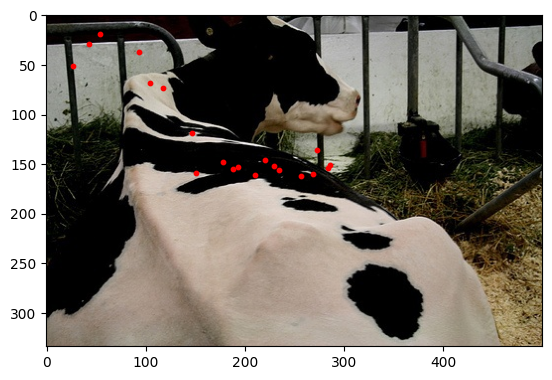

1/1 [==============================] - 0s 96ms/step


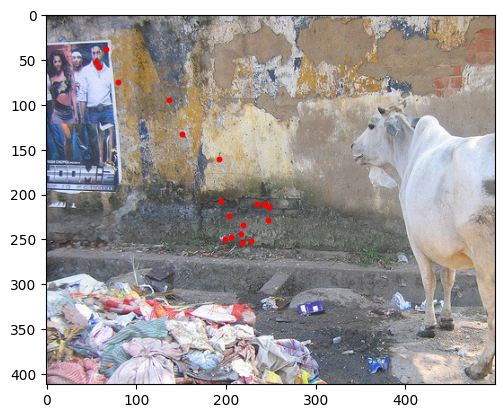

1/1 [==============================] - 0s 67ms/step


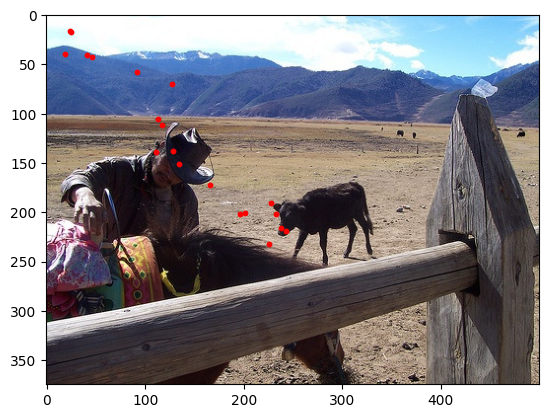

1/1 [==============================] - 0s 66ms/step


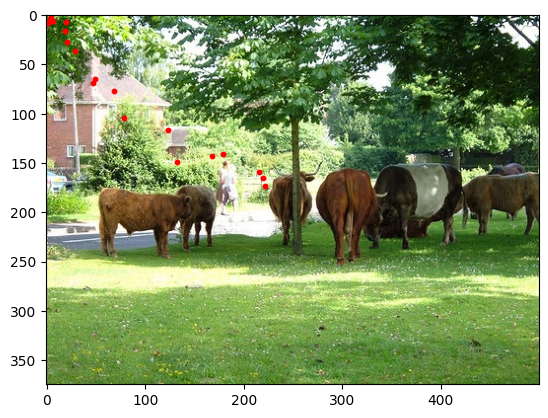

1/1 [==============================] - 0s 72ms/step


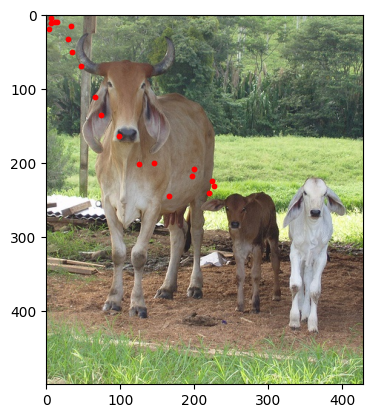

1/1 [==============================] - 0s 83ms/step


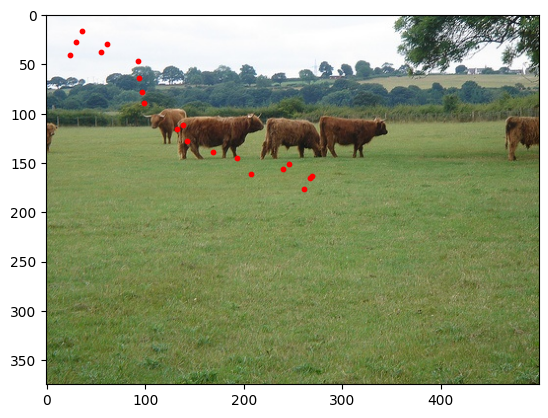

1/1 [==============================] - 0s 64ms/step


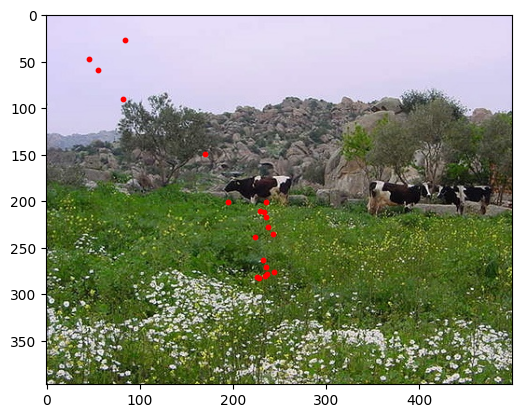

1/1 [==============================] - 0s 72ms/step


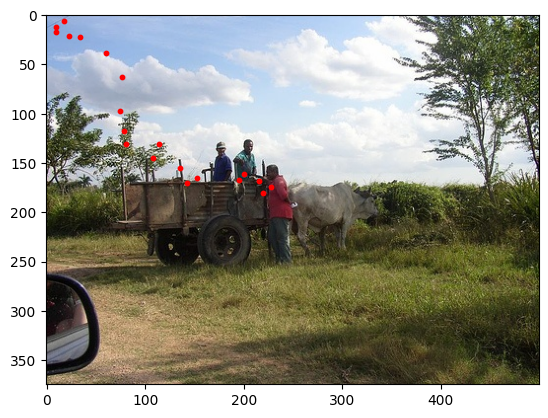

1/1 [==============================] - 0s 78ms/step


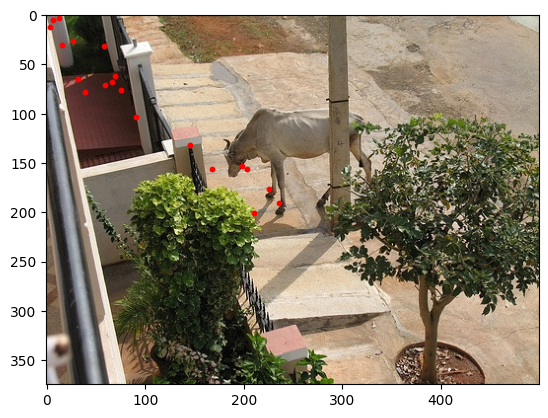

In [24]:
def infer_pose(image_info, model, output_size=(400, 400), max_keypoints=20):
    image = image_info['np_image']
    image_resized = Image.fromarray(image).resize(output_size)
    image_array = np.array(image_resized) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    keypoints_pred = model.predict(image_array)
    keypoints_pred = keypoints_pred.reshape(max_keypoints, 2)

    return keypoints_pred

for sample_item in [bovine_images[i] for i in range(10)]:
    keypoints_pred = infer_pose(sample_item, model, output_size=(400, 400), max_keypoints=20)

    plt.imshow(sample_item['np_image'])
    plt.scatter(
        keypoints_pred[:, 0] * sample_item['np_image'].shape[1],
        keypoints_pred[:, 1] * sample_item['np_image'].shape[0],
        c='r', s=10
    )
    plt.show()